# Import Libraries

In [1]:
from tensorflow.keras.utils import normalize
import tensorflow as tf
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU
import random
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate, AveragePooling2D
from keras.models import load_model
from tensorflow.keras.applications import ResNet50
from zipfile import ZipFile

# read pathes of data

In [2]:
image_directory = '/kaggle/input/modis-dataset/images'
mask_directory = '/kaggle/input/modis-dataset/annotations'
test_images = '/kaggle/input/test-data-renamed/testImages'
test_masks = '/kaggle/input/test-data-renamed/testMasks'

# read names of images in data

In [3]:
image_names = glob.glob("/kaggle/input/modis-dataset/images/*.jpg")
mask_names = glob.glob("/kaggle/input/modis-dataset/annotations/*.png")
test_images_names = glob.glob("/kaggle/input/test-data-renamed/testImages/*.tif")
test_masks_names = glob.glob("/kaggle/input/test-data-renamed/testMasks/*.tif")

print(image_names[0:6])
print("-----------------------")
print(mask_names[0:6])
print("-----------------------")
print(test_images_names[0:6])
print("-----------------------")
print(test_masks_names[0:6])

['/kaggle/input/modis-dataset/images/45.jpg', '/kaggle/input/modis-dataset/images/56.jpg', '/kaggle/input/modis-dataset/images/20.jpg', '/kaggle/input/modis-dataset/images/58.jpg', '/kaggle/input/modis-dataset/images/6.jpg', '/kaggle/input/modis-dataset/images/76.jpg']
-----------------------
['/kaggle/input/modis-dataset/annotations/41_GT.png', '/kaggle/input/modis-dataset/annotations/49_GT.png', '/kaggle/input/modis-dataset/annotations/21_GT.png', '/kaggle/input/modis-dataset/annotations/76_GT.png', '/kaggle/input/modis-dataset/annotations/15_GT.png', '/kaggle/input/modis-dataset/annotations/36_GT.png']
-----------------------
['/kaggle/input/test-data-renamed/testImages/461_test_image.tif', '/kaggle/input/test-data-renamed/testImages/380_test_image.tif', '/kaggle/input/test-data-renamed/testImages/270_test_image.tif', '/kaggle/input/test-data-renamed/testImages/424_test_image.tif', '/kaggle/input/test-data-renamed/testImages/379_test_image.tif', '/kaggle/input/test-data-renamed/test

# sort names of images in data

In [4]:
image_names = sorted(image_names, key = lambda x: (len (x), x))
mask_names = sorted(mask_names, key = lambda x: (len (x), x))
test_images_names = sorted(test_images_names, key = lambda x: (len (x), x))
test_masks_names = sorted(test_masks_names, key = lambda x: (len (x), x))

print(image_names[0:6])
print("-----------------------")
print(mask_names[0:6])
print("-----------------------")
print(test_images_names[0:6])
print("-----------------------")
print(test_masks_names[0:6])

['/kaggle/input/modis-dataset/images/0.jpg', '/kaggle/input/modis-dataset/images/1.jpg', '/kaggle/input/modis-dataset/images/2.jpg', '/kaggle/input/modis-dataset/images/3.jpg', '/kaggle/input/modis-dataset/images/4.jpg', '/kaggle/input/modis-dataset/images/5.jpg']
-----------------------
['/kaggle/input/modis-dataset/annotations/0_GT.png', '/kaggle/input/modis-dataset/annotations/1_GT.png', '/kaggle/input/modis-dataset/annotations/2_GT.png', '/kaggle/input/modis-dataset/annotations/3_GT.png', '/kaggle/input/modis-dataset/annotations/4_GT.png', '/kaggle/input/modis-dataset/annotations/5_GT.png']
-----------------------
['/kaggle/input/test-data-renamed/testImages/3_test_image.tif', '/kaggle/input/test-data-renamed/testImages/4_test_image.tif', '/kaggle/input/test-data-renamed/testImages/15_test_image.tif', '/kaggle/input/test-data-renamed/testImages/26_test_image.tif', '/kaggle/input/test-data-renamed/testImages/27_test_image.tif', '/kaggle/input/test-data-renamed/testImages/30_test_ima

# Read and resize and normalization for data

In [5]:
images = [cv2.imread(img) for img in image_names]
masks = [cv2.imread(mask,0) for mask in mask_names]
for i in range(len(images)):
    images[i] = cv2.resize(images[i] , (256,256))
    images[i] = cv2.normalize(images[i], None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    masks[i] = cv2.resize(masks[i] , (256,256))
    masks[i] = cv2.normalize(masks[i], None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
test_images = [cv2.imread(img) for img in test_images_names]
for j in range(len(test_images)):
    test_images[j] = cv2.resize(test_images[j] , (256,256))
    test_images[j] = cv2.normalize(test_images[j], None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
test_masks = [cv2.imread(img) for img in test_masks_names]
for j in range(len(test_masks)):
    test_masks[j] = cv2.resize(test_masks[j] , (256,256))
    test_masks[j] = cv2.normalize(test_masks[j], None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Size of data before Augmentation

In [6]:
print(len(images))
print(len(masks))
print(len(test_images))
print(len(test_masks))

80
80
60
60


# Data Augmentation

In [7]:
augmentation1 = iaa.Sequential([
    iaa.Affine(scale={"x": (0.5, 0.5), "y": (0.5, 0.5)})])

augmentation2 = iaa.Sequential([
    iaa.Affine(scale={"x": (1.5, 1.5), "y": (1.5, 1.5)})])

augmentation3 = iaa.Sequential([
    iaa.Affine(translate_percent={"x": (-0.2, -0.2), "y": (-0.2, -0.2)})])

augmentation4 = iaa.Sequential([
    iaa.Affine(translate_percent={"x": (0.2, 0.2), "y": (0.2, 0.2)})])

augmentation5 = iaa.Sequential([
    iaa.Affine(rotate=(-50, -50))])

augmentation6 = iaa.Sequential([
    iaa.Affine(rotate=(50, 50))])

augmentation7 = iaa.Sequential([
    iaa.Affine(shear=(-50, -50))])


augmentation8 = iaa.Sequential([
    iaa.Affine(shear=(50, 50))])

augmentation9 = iaa.Sequential([
    iaa.Fliplr(1.0)
])
    
augmentation10 = iaa.Sequential([
    iaa.Flipud(1.0)
])

all_aug = augmentation1 + augmentation2 + augmentation3 + augmentation4 + augmentation5 + augmentation6 + augmentation7 + augmentation8 + augmentation9 + augmentation10

all_img=[]
all_img += images
all_masks =[]
all_masks += masks
for i in range(len(all_aug)):
    images_aug = all_aug[i](images=images)
    masks_aug = all_aug[i](images=masks)
    all_img += images_aug
    all_masks += masks_aug

# Size of data after Augmentation

In [8]:
print(len(all_img))
print(len(all_masks))

880
880


# visualize image and its mask
img[0] is img[80]aply Augmentation1 is img[160]aply Augmentation2 is img[240]aply Augmentation3 is etc...

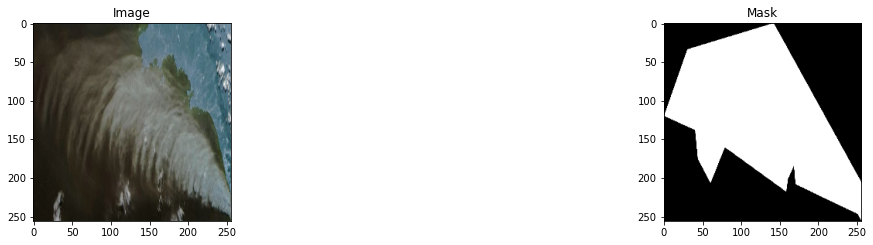

In [9]:
i=0
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(all_img[i], cmap='gray')
plt.subplot(233)
plt.title('Mask')
plt.imshow(all_masks[i], cmap='gray')

plt.show()

# convert data to numpy array

In [10]:
image_dataset = np.array(all_img)
mask_dataset = np.array(all_masks)
test_images_dataset = np.array(test_images)
test_masks_dataset = np.array(test_masks)

In [11]:
mask_dataset.resize(len(all_masks),256,256,1)
test_masks_dataset.resize(len(test_masks),256,256,1)

# print data shapes

In [12]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Test Images data shape is: ", test_images_dataset.shape)
print("Test Masks data shape is: ", test_masks_dataset.shape)

Image data shape is:  (880, 256, 256, 3)
Mask data shape is:  (880, 256, 256, 1)
Test Images data shape is:  (60, 256, 256, 3)
Test Masks data shape is:  (60, 256, 256, 1)


# split data for train and test

In [13]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=42)

# print data shapes after split

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(704, 256, 256, 3)
(704, 256, 256, 1)
(88, 256, 256, 3)
(88, 256, 256, 1)
(88, 256, 256, 3)
(88, 256, 256, 1)


# Build ASPP module for DeepLabV3+ model

In [15]:
# Atrous Spatial Pyramid Pooling ( ASPP )

def ASPP(inputs):
    shape = inputs.shape
    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)
    
    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

# Build our DeepLab V3 Plus model

In [16]:
def DeepLabV3Plus(shape):
    """ Inputs """
    inputs = Input(shape)

    """ Pre-trained ResNet50 """
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(1, (1, 1), name='output_layer')(x)
    x = Activation('sigmoid')(x)

    """ Model """
    model = Model(inputs=inputs, outputs=x)
    return model

# read data shapes

In [17]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
input_shape

(256, 256, 3)

# Call model and print his summary

In [18]:
model = DeepLabV3Plus(input_shape)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_____________________________

# train model

In [19]:
history = model.fit(X_train, y_train, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_val, y_val), 
                    shuffle=True)

Epoch 1/100
22/22 [==============================] - 31s 670ms/step - loss: 0.4595 - accuracy: 0.8032 - val_loss: 3.4984 - val_accuracy: 0.6239
Epoch 2/100
22/22 [==============================] - 13s 576ms/step - loss: 0.2686 - accuracy: 0.8731 - val_loss: 2.0003 - val_accuracy: 0.5949
Epoch 3/100
22/22 [==============================] - 13s 577ms/step - loss: 0.2358 - accuracy: 0.8888 - val_loss: 4.1296 - val_accuracy: 0.6350
Epoch 4/100
22/22 [==============================] - 13s 575ms/step - loss: 0.2203 - accuracy: 0.8962 - val_loss: 1.6217 - val_accuracy: 0.6670
Epoch 5/100
22/22 [==============================] - 13s 577ms/step - loss: 0.1881 - accuracy: 0.9121 - val_loss: 1.0401 - val_accuracy: 0.6211
Epoch 6/100
22/22 [==============================] - 13s 575ms/step - loss: 0.1801 - accuracy: 0.9150 - val_loss: 0.7626 - val_accuracy: 0.5720
Epoch 7/100
22/22 [==============================] - 13s 575ms/step - loss: 0.1618 - accuracy: 0.9242 - val_loss: 0.9910 - val_accuracy:

# Evaluation of independent dataset

In [20]:
loss, accuracy = model.evaluate(test_images_dataset, test_masks_dataset)

# Print the test loss and accuracy
print('Test loss:', loss)
print('Test accuracy:', accuracy)

2/2 [==============================] - 1s 1s/step - loss: 1.6891 - accuracy: 0.6529
Test loss: 1.6890813112258911
Test accuracy: 0.652893602848053


# Evaluation of dependent dataset

In [21]:
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print('Test loss:', loss)
print('Test accuracy:', accuracy)

3/3 [==============================] - 1s 148ms/step - loss: 0.3680 - accuracy: 0.9178
Test loss: 0.3680124580860138
Test accuracy: 0.9177908301353455


# Save the model for future use

In [22]:
# model.save('DeepLabv3 model.hdf5')

# Load previously saved model

In [23]:
# model = load_model("#model path#", compile=False)

# Visualize loss plot and accurcy plot for both training and validation

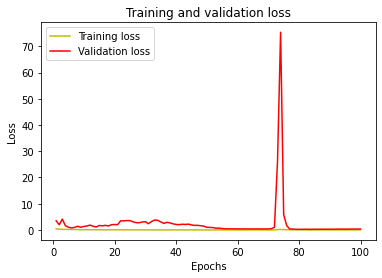

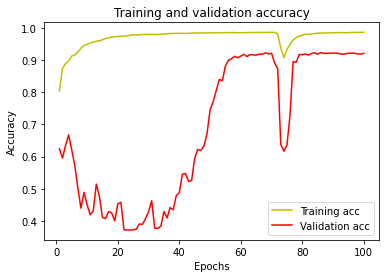

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict our model

In [25]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

# Model evaluation by Intersection Over Union(IOU)

In [26]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8500781


# Visaulize our prediction

(1, 256, 256, 3)
(256, 256)


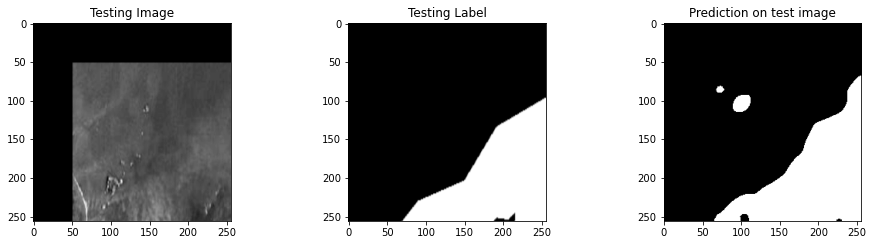

In [27]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()